In [180]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.ndimage as ndimage
import skimage

In [181]:
image = np.load('data/kidney/test/input/case_00011.npy')
label = np.load('data/kidney/test/label/case_00011.npy')
# WHD -> DHW
image = np.transpose(image, (2, 1, 0))
label = np.transpose(label, (2, 1, 0))

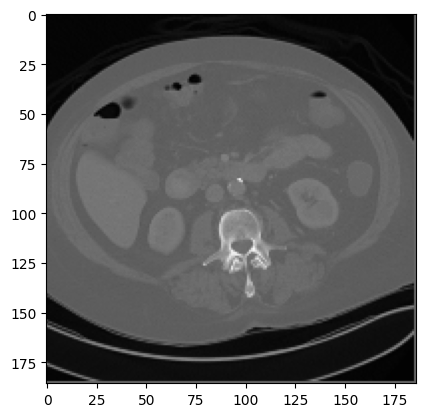

In [182]:
plt.imshow(image[64, ...], cmap='gray')

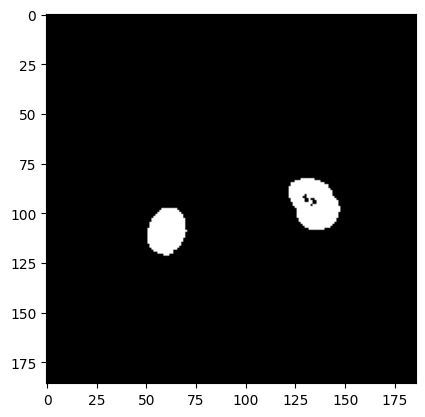

In [183]:
plt.imshow(label[64, ...], cmap='gray')

In [479]:
def get_affine_from_bbox_3d(z, y, x, d, h, w, original_shape):
  """
  Returns an affine transformation matrix in OpenCV-expected format that
  will crop the image to the bounding box.
  """
  original_d, original_h, original_w = original_shape
  scale_x = original_w / w
  scale_y = original_h / h
  scale_z = original_d / d
  M = np.array([[scale_z, 0, 0, -z * scale_z], [0, scale_y, 0, -y * scale_y], [0, 0, scale_x, -x * scale_x]])
  return M

In [480]:
def get_bbox_3d(input, label, padding=0, bbox_aug=0):
  label_th = label.copy()
  label_th[label_th > 0.5] = 1
  label_th[label_th <= 0.5] = 0
  label_th = label_th.astype(np.uint8)

  # use skimage to get 3d bbox
  bbox = skimage.measure.regionprops(label_th)[0].bbox
  z, y, x, d, h, w = bbox
  w = w - x
  h = h - y
  d = d - z
  
  if bbox_aug > 0:
    augs = np.random.uniform(-bbox_aug * min(w, h), bbox_aug * min(w, h), size=6)
    x += augs[0]
    y += augs[1]
    w += augs[2]
    h += augs[3]
    z += augs[4]
    d += augs[5]

  x -= padding
  y -= padding
  w += 2 * padding
  h += 2 * padding
  z -= padding
  d += 2 * padding

  return z, y, x, d, h, w

In [481]:
z, y, x, d, h, w = get_bbox_3d(image, label)

In [482]:
print(x, y, z, d, h, w)

49 83 25 52 49 107


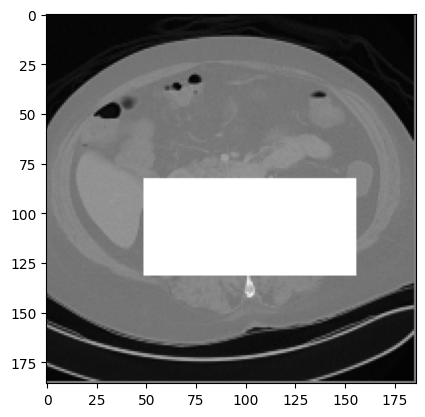

In [483]:
# show bbox on image
image_bbox = image.copy()
image_bbox[z:z+d, y:y+h, x:x+w] = 1000
plt.imshow(image_bbox[64, ...], cmap='gray')

In [484]:
affine = get_affine_from_bbox_3d(*get_bbox_3d(image, label), image.shape)
affine = np.concatenate([affine, np.array([[0, 0, 0, 1]])], axis=0)

In [485]:
image_t = ndimage.affine_transform(image, np.linalg.inv(affine), order=1)

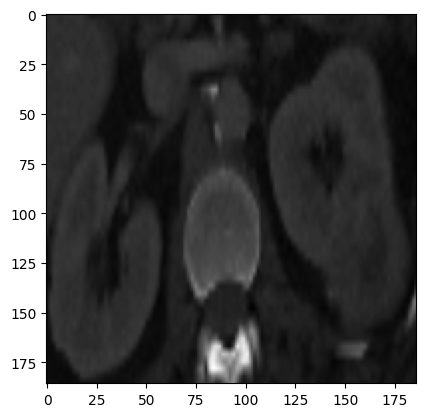

In [486]:
plt.imshow(image_t[64, ...], cmap='gray')

In [487]:
label_t = ndimage.affine_transform(label, np.linalg.inv(affine), order=0)

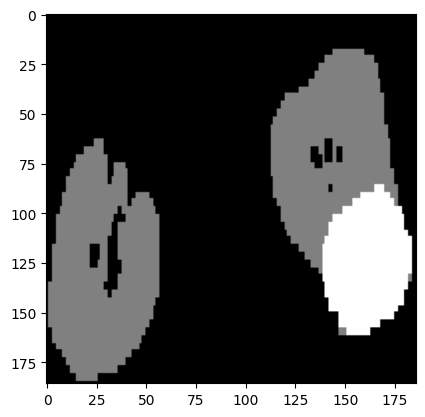

In [488]:
plt.imshow(label_t[64, ...], cmap='gray')

In [494]:
def get_theta_from_bbox_3d(z, y, x, d, h, w, original_shape):
  """
  Returns an affine transformation matrix in PyTorch-expected format that 
  will crop the image to the bounding box.
  """
  original_d, original_h, original_w = original_shape
  scale_x = original_w / w
  scale_y = original_h / h
  scale_z = original_d / d

  x_t = (x + w / 2) / original_w * 2 - 1
  y_t = (y + h / 2) / original_h * 2 - 1
  z_t = (z + d / 2) / original_d * 2 - 1

  theta = np.array([[1 / scale_x, 0, 0, x_t], [0, 1 / scale_y, 0, y_t], [0, 0, 1 / scale_z, z_t]], dtype=np.float32)
  return theta


In [508]:
from albumentations.pytorch import ToTensorV2

transformed = ToTensorV2()(image=image, mask=label)
image_tensor = transformed['image']
label_tensor = transformed['mask']
image_tensor = image_tensor.unsqueeze(0)
label_tensor = label_tensor.unsqueeze(0)

In [509]:
image_tensor.shape

torch.Size([1, 186, 186, 186])

In [510]:
import torch.nn.functional as F

theta = get_theta_from_bbox_3d(*get_bbox_3d(image, label), image.shape)
theta = torch.from_numpy(theta).unsqueeze(0)

input = label_tensor.unsqueeze(0).float()
print(theta.shape)
grid = F.affine_grid(theta, input.shape, align_corners=True)
image_tt = F.grid_sample(input, grid, align_corners=True)

torch.Size([1, 3, 4])


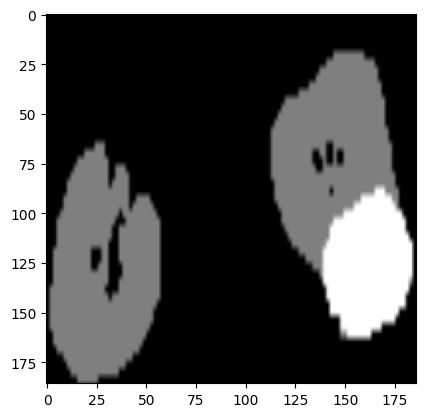

In [498]:
image_tt = image_tt.squeeze().numpy()
plt.imshow(image_tt[64, ...], cmap='gray')

In [506]:
import monai
unet = monai.networks.nets.FlexibleUNet(
  in_channels=1,
  out_channels=1,
  backbone='efficientnet-b0',
  pretrained=True,
)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /home/marinbenc/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 31.5MB/s]


In [507]:
unet

FlexibleUNet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (_conv_stem_padding): ConstantPad2d(padding=(0, 1, 0, 1), value=0.0)
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (_blocks): Sequential(
      (0): Sequential(
        (0): MBConvBlock(
          (_expand_conv): Identity()
          (_expand_conv_padding): Identity()
          (_bn0): Identity()
          (_depthwise_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
          (_depthwise_conv_padding): ConstantPad2d(padding=(1, 1, 1, 1), value=0.0)
          (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (_se_adaptpool): AdaptiveAvgPool2d(output_size=1)
          (_se_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (_se_reduce_padding): Identity()
          (_se_expand): Conv2d(8, 32, kernel_size=(1, 1), s

(1, 186, 186, 186)


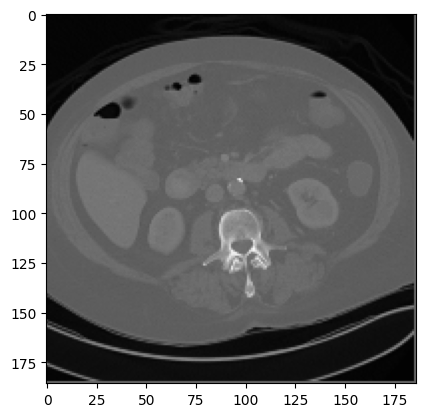

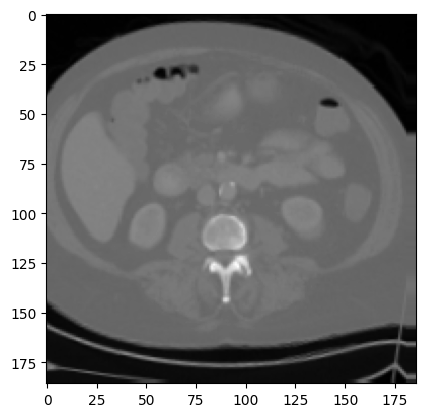

In [593]:
import monai
import monai.transforms as T
import time

transform = T.Compose([
  T.RandAffined(prob=1, keys=['image'], mode='bilinear', padding_mode='reflection',
    rotate_range=(0.15, 0.15, 0.15), translate_range=(0.1, 0.1, 0.1), scale_range=(0.1, 0.1, 0.1)),
  T.RandGridDistortiond(prob=1, keys=['image'], distort_limit=0.1),
])

transform.set_random_state(time.time() * 1000)

# add channel dim
image_ = image[None, ...]
print(image_.shape)

image_transformed = transform({'image': image_})['image']
plt.imshow(image[64, ...], cmap='gray')
plt.show()
plt.imshow(image_transformed[0][64, ...], cmap='gray')